# Entropy-regularized Contextual Dropout

## Environment Setup 

In [2]:
%conda install numpy matplotlib tqdm pytorch torchvision

Channels:
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/a/.pyenv/versions/anaconda3-2024.10-1/envs/project

  added / updated specs:
    - matplotlib
    - numpy
    - pytorch
    - torchvision
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.2.25  |       hecd8cb5_0         131 KB
    certifi-2025.4.26          |  py312hecd8cb5_0         157 KB
    matplotlib-3.9.2           |  py312hecd8cb5_1           8 KB
    openssl-3.0.16             |       h184c1cd_0         4.6 MB
    pytorch-2.3.1              |cpu_py312hf01ac55_0        61.4 MB
    torchvision-0.18.1         |cpu_py312h937ada3_0         9.5 MB
    tqdm-4.67.1                |  py312h8e4b320_0         160 KB
    ------------------------------------------------------------
                                           Total:        75.9 MB

In [1]:
from typing import Callable

import torch
import torch.nn as nn            # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim      # optimizer
import torch.utils.data          # dataloader
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt
import tqdm

torch.manual_seed(42)

We will use MNIST as the benchmark as in the reference paper (see Appendix C1).

In [2]:
# Download the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Load into torch datasets
train_dataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float(), mnist_train.targets.long())
test_dataset = torch.utils.data.TensorDataset(mnist_test.data.unsqueeze(1).float(), mnist_test.targets.long())


## Contextual Dropout Modules

We implement contextual dropout in two parts:

* The module `ContextualDropoutMask` is a neural net
computing the dropout mask for an input $x$
as a function of $x$. 

* The function `EntropyRegularizer` is used as a regularizer 
during training to train the contextual dropout neural net. 

In [9]:
class ContextualDropoutMask(nn.Module):
    def __init__(
        self,
        input_dim,
        bottleneck_factor = 10, # the \gamma in the paper
        activation_fn: Callable = F.gelu,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim // bottleneck_factor + 1
        self.activation_fn = activation_fn

        self.w1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.w2 = nn.Linear(self.hidden_dim, self.input_dim) # output dim must match input

    def forward(self, x):
        x = self.w1(x)
        x = self.activation_fn(x)

        logits = self.w2(x)
        # transform to probabilities mask
        mask = F.sigmoid(logits)
        return mask

In [114]:
class EntropyRegularizer(nn.Module):
    """
    Computes the regularization loss
    using relative entropy
    with respect to a Bernoulli distribution
    with probability p_target
    """
    def __init__(
            self,
            p_target,
            eps=1e-8 # must specify some precision or it'll bug out #TODO maybe unnecessary with builtin nn.BCELoss?
    ):
        super().__init__()
        self.p_target = p_target
        self.cross_entropy = nn.BCELoss()

    def forward(self, p):
        # the target map
        target = torch.full_like(p, self.p_target)

        loss = self.cross_entropy(p, target) # note the opposite convention used in nn.BCELoss
        return loss




## Building the two networks

To measure performance against regular dropout,
we implement the same task with two neural networks
which only differ in the kind of dropout used.

In [116]:
class SimpleMLP(nn.Module): # the control net
    def __init__(
        self,
        input_dim: int = 784,
        output_dim: int = 10,
        hidden_dim_list: list = [100, 100],
        activation_fn: Callable = F.gelu,
        dropout_prob: float = 0.2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list
        self.activation_fn = activation_fn
        self.dropout = torch.nn.Dropout(p = dropout_prob) # simple, global dropout

        self.hidden_layers = nn.ModuleList() # for the hidden layers, see https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        current_dim = self.input_dim
        for dim in self.hidden_dim_list:
            self.hidden_layers.append(
                nn.Linear(current_dim, dim)
            )
            current_dim = dim
        self.last_layer = nn.Linear(current_dim, self.output_dim)

    def forward(self, x):
        # flatten the input for the MLP
        x = x.view(x.size(0), -1)
        if self.training:
            x = self.dropout(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            if self.training:
                x = self.dropout(x)
            x = self.activation_fn(x)
        
        x = self.last_layer(x) 
        return x

In [117]:
class ContextualDropoutMLP(nn.Module):
    def __init__(
        self,
        input_dim: int = 784,
        output_dim: int = 10,
        hidden_dim_list: list = [100, 100],
        activation_fn: Callable = F.gelu,
        dropout_prob: float = 0.2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list
        self.activation_fn = activation_fn
        self.dropout_prob = dropout_prob

        self.hidden_layers = nn.ModuleList() # for the hidden layers, see https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        current_dim = self.input_dim
        for dim in self.hidden_dim_list:
            self.hidden_layers.append(
                nn.Linear(current_dim, dim)
            )
            current_dim = dim

        self.last_layer = nn.Linear(current_dim, self.output_dim)

        # haven't found a clean way to do this,
        # but we must store the losses for each dropout
        # computed during a forward pass.
        # we start by storing each dropout module:
        self.dropout_modules = nn.ModuleList()
        self.dropout_modules.append(
            ContextualDropoutMask(input_dim=self.input_dim)
        )
        for dim in self.hidden_dim_list:
            self.dropout_modules.append(
                ContextualDropoutMask(input_dim=dim)
            )
        # we now attach hooks to each dropout module:
        # see https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook
        self.dropout_losses = []
        for module in self.dropout_modules:
            module.register_forward_hook(self.hook_init())

    def hook_init(self):
        keep_p_target = 1.0 - self.dropout_prob
        loss_fn = EntropyRegularizer(p_target=keep_p_target)
        def hook(module, input, output):
            p = output
            loss = loss_fn(p)
            self.dropout_losses.append(loss)
        return hook


    def forward(self, x):
        # flatten the input for the MLP
        x = x.view(x.size(0), -1)
        self.dropout_losses = []
        if self.training:
            drop = self.dropout_modules[0]
            p = drop(x)
            mask = torch.bernoulli(p)
            x = x * mask
        for l, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
            if self.training:
                drop = self.dropout_modules[l + 1]
                p = drop(x)
                mask = torch.bernoulli(p)
                x = x * mask
            x = self.activation_fn(x)
        x = self.last_layer(x) 
        return x

## Training

This training function is modified from the CNN from Problem 5 in the first assignment.

In [118]:
def plot_metrics(train_metrics, test_metrics, xlabel, ylabel, title):
    plt.plot(train_metrics, label="Training")
    plt.plot(test_metrics, label="Testing")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def train(model, loss_fn, train_loader, test_loader, optimizer, epochs=5, lambda_dropout=1.0):
    """Train the model.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        test_loader: the testing data loader
        optimizer: the optimizer
        epochs: the number of epochs to train
    Returns:
        train_losses: the training losses
        test_losses: the testing losses
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    loop = tqdm.tqdm(range(1, epochs + 1))

    for epoch in loop:
        # train the model for one epoch
        train_loss, train_accuracy = train_epoch(model, loss_fn, train_loader, optimizer, lambda_dropout=lambda_dropout)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # test the model for one epoch
        test_loss, test_accuracy = test_epoch(model, loss_fn, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_loss, test_loss=test_loss, train_accuracy=train_accuracy, test_accuracy=test_accuracy)
    return train_losses, test_losses, train_accuracies, test_accuracies


def train_epoch(model, loss_fn, train_loader, optimizer, lambda_dropout=1.0):
    """Train the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        optimizer: the optimizer
    Returns:
        train_loss: the loss of the epoch
    """
    model.train()  # set model to training mode
    total_train_loss = 0
    total_correct = 0
    total_samples = 0
    train_accuracy = 0

    for batch_idx, (data, target) in enumerate(train_loader): # Q: why do we care about batch_idx?
        optimizer.zero_grad()

        output = model(data)
        task_loss = loss_fn(output, target)

        # inelegant hack
        # to determine whether we're training
        # our module or the control
        if hasattr(model, 'dropout_losses') and model.dropout_losses:
            entropy_reg = sum(model.dropout_losses)
        else:
            entropy_reg = 0.0
        
        loss = task_loss + lambda_dropout * entropy_reg

        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        total_train_loss += loss.item() * data.size(0)

        _, predicted = torch.max(output.data, 1)

        total_correct += (predicted == target).sum().item()

        total_samples += target.size(0)

        # correct = sum([pred == actual for pred, actual in zip(predicted, target)]).item()
        # train_accuracy += correct / len(output)

    # batches = len(train_loader)
    train_loss = total_train_loss / total_samples
    train_accuracy = total_correct / total_samples

    return train_loss, train_accuracy

def test_epoch(model, loss_fn, test_loader):
    """Test the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        test_loader: the testing data loader
    Returns:
        test_loss: the loss of the epoch
    """
    model.eval()  # set model to evaluation mode
    total_test_loss = 0
    total_correct = 0
    total_samples = 0
    test_accuracy = 0

    with torch.no_grad():  # disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            loss = loss_fn(output, target)

            total_test_loss += loss.item() * data.size(0)
            # test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)

            # correct = sum([pred == actual for pred, actual in zip(predicted, target)]).item()
            # test_accuracy += correct / len(output)

        # batches = len(test_loader)
        test_loss = total_test_loss / total_samples
        test_accuracy = total_correct / total_samples

    return test_loss, test_accuracy

## Finding the best $\lambda$

The new loss function involves a hyperparameter $\lambda$,
which needs to be tuned.
We use a simple order-of-magnitude (logarithmic) grid search to find the best one for our task.

In [125]:
batch_size = 128
learning_rate = 1e-3
epochs = 30
input_dim = 784
hidden_dim_list = [300, 100]
output_dim = 10

loss_fn = torch.nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle since we're looping this
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

lambda_exp_list = np.arange(-1.0, 1.1, 1.0) 
lambdas = 10 ** lambda_exp_list

best_acc = 0.0
best_lambda = lambdas[0]
for current_lambda in lambdas:
    model = ContextualDropoutMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, dropout_prob=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    train_losses, test_losses, train_accuracies, test_accuracies = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs, lambda_dropout=current_lambda)
    best_test_acc = np.average(test_accuracies[-5:]) # compute average to account for noise
    if best_test_acc > best_acc:
        best_acc = best_test_acc
        best_lambda = current_lambda

    
print(f"best lambda: {best_lambda}")
print(f"best accuracy: {best_acc}")

Epoch 30: 100%|██████████| 30/30 [09:32<00:00, 19.09s/it, test_accuracy=0.978, test_loss=0.145, train_accuracy=0.973, train_loss=15.1]

best lambda: 0.1
best accuracy: 0.97994


This returns $\lambda = 0.1 $, which will be used in what follows.

## Comparing performance

We now compare the performance of our model with that of the control.
We keep all comparable values the same.

### Our model:

Epoch 60: 100%|██████████| 60/60 [23:23<00:00, 23.39s/it, test_accuracy=0.978, test_loss=0.189, train_accuracy=0.975, train_loss=4.62]


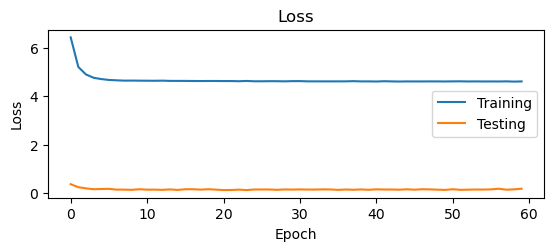

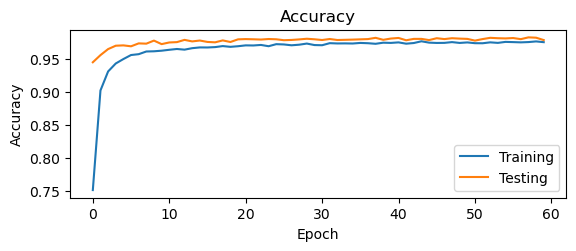

In [126]:
batch_size = 128
learning_rate = 1e-3
epochs = 60
input_dim = 784
hidden_dim_list = [300, 100]
output_dim = 10
lambda_mult = 3.0

model = ContextualDropoutMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, dropout_prob=0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses, test_losses, train_accuracies, test_accuracies = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs, lambda_dropout=lambda_mult)

#save model
save_path = 'data/model.pth'
torch.save(model.state_dict(), save_path)

plt.subplot(2, 1, 1)
plot_metrics(train_losses, test_losses, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies, test_accuracies, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### The control:

Epoch 60: 100%|██████████| 60/60 [08:23<00:00,  8.38s/it, test_accuracy=0.979, test_loss=0.11, train_accuracy=0.973, train_loss=0.101]  


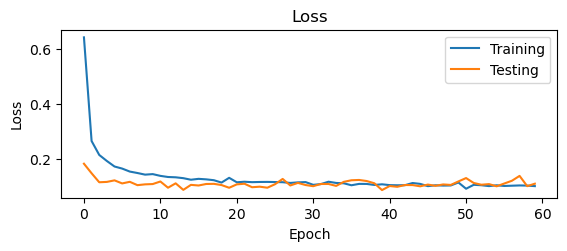

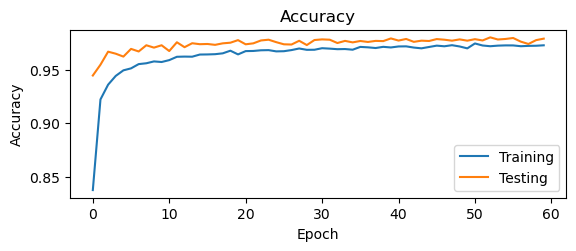

In [127]:
batch_size = 128
learning_rate = 1e-3
epochs = 60
input_dim = 784
hidden_dim_list = [300, 100]
output_dim = 10

model_ctrl = SimpleMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, dropout_prob=0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ctrl.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses_ctrl, test_losses_ctrl, train_accuracies_ctrl, test_accuracies_ctrl = train(model_ctrl, loss_fn, train_loader, test_loader, optimizer, epochs=epochs, lambda_dropout=0.0)

#save model
save_path = 'data/model_ctrl.pth'
torch.save(model_ctrl.state_dict(), save_path)

plt.subplot(2, 1, 1)
plot_metrics(train_losses_ctrl, test_losses_ctrl, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies_ctrl, test_accuracies_ctrl, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### A closer look at the accuracy

It's not easy to see the difference in performance
between the two graphs.

First, the range is too wide, since 
the graph captures the accuracy curve since initialization.

Second, the curves are very jagged due to the sampling procedure.

To remedy the first point,
we restrict our data from the 20th epoch onward.

To remedy the second point,
we display moving averages of the accuracy
over a large enough window.

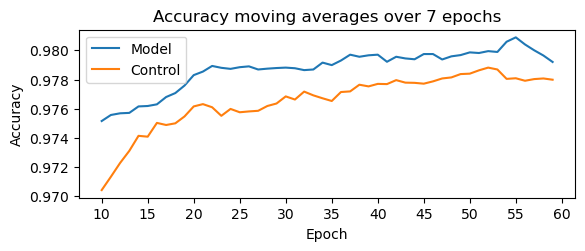

In [143]:
display_start_epoch = 10

fit_acc = test_accuracies[display_start_epoch:]
fit_acc_ctrl = test_accuracies_ctrl[display_start_epoch:]

def moving_avg(arr, window_size):
    left_offset = window_size // 2
    right_offset = window_size - left_offset - 1
    padded_arr = [arr[0]] * left_offset + arr + [arr[-1]] * right_offset
    avgs = []
    for i, _ in enumerate(arr):
        window = padded_arr[i:i+window_size]
        avgs.append(np.average(window))
    return avgs

moving_avg_window_size = 7

fit_acc = moving_avg(fit_acc, moving_avg_window_size)
fit_acc_ctrl = moving_avg(fit_acc_ctrl, moving_avg_window_size)

ticks = np.arange(len(fit_acc) + 1)
epochs = ticks + display_start_epoch

ticks = ticks[::5]
epochs = epochs[::5]


plt.subplot(2, 1, 1)
plt.plot(fit_acc, label="Model")
plt.plot(fit_acc_ctrl, label="Control")
plt.xticks(ticks=ticks, labels=epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Accuracy moving averages over {moving_avg_window_size} epochs")
plt.legend()
plt.show()

### Confusion Matrix

We finish by plotting the confusion matrices of the model and the control.

Confusion matrix for the model:
[[ 969    1    1    1    0    1    5    2    0    0]
 [   0 1127    2    1    0    0    4    0    1    0]
 [   1    1 1019    2    1    0    3    3    2    0]
 [   0    0    4  985    1   13    0    3    2    2]
 [   1    0    0    0  953    0    9    3    0   16]
 [   2    0    0    1    1  875    6    0    3    4]
 [   4    4    1    0    3    2  944    0    0    0]
 [   1   10   19    1    2    0    0  987    4    4]
 [   1    2    2    5    3    7    6    2  943    3]
 [   6    6    1    4    6    3    0    3    3  977]]
Confusion matrix for the control:
[[ 974    1    0    0    0    1    2    1    1    0]
 [   0 1126    2    2    0    0    1    2    2    0]
 [   7    1 1007    6    1    0    1    4    5    0]
 [   1    0    2  990    0    7    0    3    5    2]
 [   1    0    1    0  946    0    9    1    0   24]
 [   2    0    0    5    0  869    9    0    5    2]
 [   4    3    0    0    0    3  942    0    5    1]
 [   1    3    7    2    0    0 

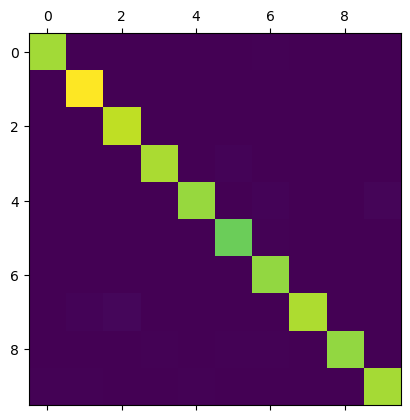

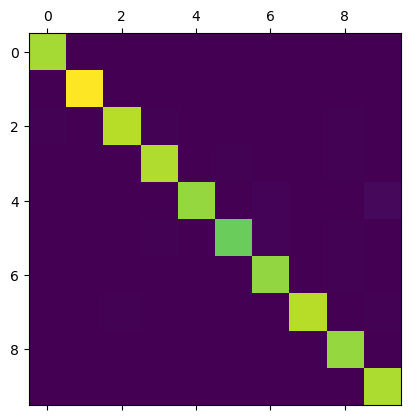

In [149]:
from sklearn.metrics import confusion_matrix

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

dataiter = iter(test_loader)
data, target = next(dataiter)

model.load_state_dict(torch.load('data/model.pth'))
model.eval()  # set model to evaluation mode

outputs = model(data)
_, predicted = torch.max(outputs, 1)

conf = confusion_matrix(target, predicted)

print("Confusion matrix for the model:")
print(conf)
plt.matshow(conf)

model_ctrl.load_state_dict(torch.load('data/model_ctrl.pth'))
model.eval()  # set model to evaluation mode

outputs = model_ctrl(data)
_, predicted = torch.max(outputs, 1)

conf = confusion_matrix(target, predicted)

print("Confusion matrix for the control:")
print(conf)
plt.matshow(conf)

